# Análisis de Sensibilidad de Hiperparámetros

**Revisión y preparación**

Inciamos con la carga de la data sintética de 500 registros de nuestro modelo RandomForestClassifier, que clasifica la categoría del tipo de cliente basado en las variables más relevantes de la factura extraída

                                 precision    recall  f1-score   support

                      Ejecutivo       1.00      1.00      1.00        20
                     Estudiante       0.91      1.00      0.95        20
                       Familiar       1.00      0.90      0.95        20
                          Rural       1.00      1.00      1.00        20
Transporte pÃºblico / comercial       1.00      1.00      1.00        20

                       accuracy                           0.98       100
                      macro avg       0.98      0.98      0.98       100
                   weighted avg       0.98      0.98      0.98       100

Modelo guardado en: verifactura_rf_model_skl1.7.pkl


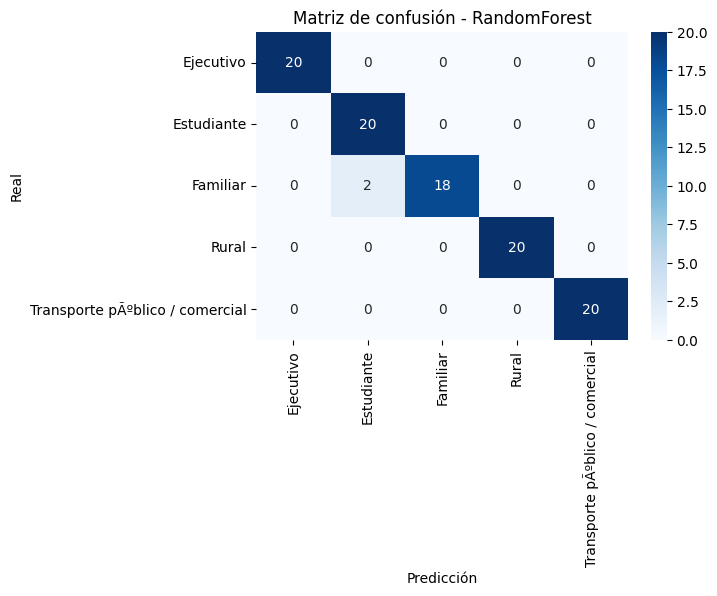

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Carga datos
df = pd.read_excel("/content/sample_data/verifactura_dataset_500.xlsx")

X = df[["marca","tipo","clase","capacidad","combustible","ruedas","total"]]
y = df["categoria"]

# 2) Preprocesador
cat = ["marca","tipo","clase","combustible"]
num = ["capacidad","ruedas","total"]

pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
        ("num", StandardScaler(), num),
    ]
)

# 3) Modelo
pipe = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

# 4) Split y entrenamiento
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe.fit(Xtr, ytr)

# 5) Métricas rápidas
yp = pipe.predict(Xte)
print(classification_report(yte, yp))

# 6) Guardar artefacto entrenado con tu versión actual
out_path = "verifactura_rf_model_skl1.7.pkl"
joblib.dump(pipe, out_path)
print(f"Modelo guardado en: {out_path}")

# 7) Matriz de confusión
cm = confusion_matrix(yte, yp, labels=pipe.named_steps["rf"].classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipe.named_steps["rf"].classes_, yticklabels=pipe.named_steps["rf"].classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RandomForest")
plt.show()

**Definición de hiperparámetros**

Modelo Random Forest: n_estimators (número de árboles); max_depth (profundidad máxima); learning_rate (solo para boosting); min_samples_split o min_child_weight; max_features o subsample

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
import numpy as np

# === Datos ===
df = pd.read_csv("/content/sample_data/verifactura_dataset_500.csv")
X = df[["marca","tipo","clase","capacidad","combustible","ruedas","total"]]
y = df["categoria"]

# === Preprocesador ===
cat = ["marca","tipo","clase","combustible"]
num = ["capacidad","ruedas","total"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
    ("num", StandardScaler(), num),
])

# === Modelo base ===
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

# === Espacio de búsqueda ===
param_distributions = {
    "classifier__n_estimators": randint(150, 800),
    "classifier__max_depth": [None] + list(range(4, 31)),
    "classifier__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "classifier__min_samples_split": randint(2, 21),
    "classifier__min_samples_leaf": randint(1, 11),
    "classifier__max_samples": uniform(0.5, 0.5),  # [0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=60,                 # 30 si quieres ir más rápido
    scoring="f1_macro",        # o "accuracy"
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X, y)
print("Mejor puntaje (cv):", search.best_score_)
print("Mejores hiperparámetros:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_model = search.best_estimator_
# Ejemplo de predicción
ejemplo = pd.DataFrame([{
    "marca": "TOYOTA",
    "tipo": "SUV",
    "clase": "AUTOMOVIL",
    "capacidad": 5,
    "combustible": "GASOLINA",
    "ruedas": 4,
    "total": 32000
}])
print("\nPredicción:", best_model.predict(ejemplo)[0])
print("Probas:", dict(zip(best_model.named_steps["classifier"].classes_,
                         best_model.predict_proba(ejemplo)[0])))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejor puntaje (cv): 0.983967423248553
Mejores hiperparámetros:
  classifier__max_depth: 11
  classifier__max_features: log2
  classifier__max_samples: 0.9744427686266666
  classifier__min_samples_leaf: 2
  classifier__min_samples_split: 10
  classifier__n_estimators: 495

Predicción: Ejecutivo
Probas: {'Ejecutivo': np.float64(0.7220600423400856), 'Estudiante': np.float64(0.03486095562143365), 'Familiar': np.float64(0.17869186809810136), 'Rural': np.float64(0.04285417334087358), 'Transporte público / comercial': np.float64(0.021532960599506438)}


**Prueba manual**

Predicción de Categoría ingresando las variables relevantes del modelo, predice una variable categórica basado en 4 variables categóricas y 3 numéricas

In [ ]:
import joblib
import pandas as pd

# === 1. Cargar el modelo entrenado ===
model_path = "/content/verifactura_rf_model_skl1.7.pkl"  # usamos la ruta local
model = joblib.load(model_path)

# === 2. Crear un nuevo ejemplo de factura ===
nueva_factura = pd.DataFrame([{
    "marca": "CHEVROLET",
    "tipo": "SEDAN",
    "clase": "AUTOMOVIL",
    "capacidad": 5,
    "combustible": "GASOLINA",
    "ruedas": 4,
    "total": 17900
}])

# === 3. Ejecutar la predicción ===
prediccion = model.predict(nueva_factura)[0]
probabilidades = model.predict_proba(nueva_factura)[0]

# === 4. Mostrar resultado ===
print(f"Categoría predicha: {prediccion}")
print("\nProbabilidades por clase:")
for clase, prob in zip(model.classes_, probabilidades):
    print(f"{clase}: {prob:.2f}")

Categoría predicha: Familiar

Probabilidades por clase:
Ejecutivo: 0.06
Estudiante: 0.12
Familiar: 0.81
Rural: 0.01
Transporte público / comercial: 0.01


**Exploración sistémica**

Usando los datos de entrenamiento, se configuró RandomizedSearchCV, y se ejecutaron 50 combinaciones con validación cruzada, el modelo óptimo se guarda en verifactura_rf_best_C.pkl

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
import joblib

# === 1. Cargar datos ===
df = pd.read_csv("/content/sample_data/verifactura_dataset_500.csv")
X = df[["marca","tipo","clase","capacidad","combustible","ruedas","total"]]
y = df["categoria"]

# === 2. Preprocesamiento ===
cat = ["marca","tipo","clase","combustible"]
num = ["capacidad","ruedas","total"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
    ("num", StandardScaler(), num)
])

# === 3. Modelo base ===
rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", rf)
])

# === 4. Definimos varios "bloques" de rangos para probar ===
# Esto permite experimentar distintos espacios de búsqueda más amplios o más finos
espacios_prueba = {
    "A": {  # Rango estándar medio
        "classifier__n_estimators": randint(150, 400),
        "classifier__max_depth": [None] + list(range(5, 21)),
        "classifier__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
        "classifier__min_samples_split": randint(2, 10),
        "classifier__min_samples_leaf": randint(1, 5),
        "classifier__max_samples": uniform(0.7, 0.3)
    },
    "B": {  # Árboles más profundos y amplios
        "classifier__n_estimators": randint(400, 800),
        "classifier__max_depth": [None] + list(range(15, 41)),
        "classifier__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0],
        "classifier__min_samples_split": randint(2, 20),
        "classifier__min_samples_leaf": randint(1, 8),
        "classifier__max_samples": uniform(0.5, 0.5)
    },
    "C": {  # Configuración ligera (rápida)
        "classifier__n_estimators": randint(100, 250),
        "classifier__max_depth": [None] + list(range(3, 15)),
        "classifier__max_features": ["sqrt", "log2"],
        "classifier__min_samples_split": randint(2, 8),
        "classifier__min_samples_leaf": randint(1, 4),
        "classifier__max_samples": uniform(0.8, 0.2)
    }
}

# === 5. Validación cruzada ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 6. Ejecución de las pruebas de hiperparámetros ===
resultados_globales = []

for nombre, param_dist in espacios_prueba.items():
    print(f"\n🔹 Iniciando búsqueda aleatoria para espacio '{nombre}'...")
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=50,              # 50 combinaciones aleatorias por bloque
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X, y)

    print(f"\n✅ Espacio {nombre} completado")
    print("   Mejor F1-macro (CV):", round(search.best_score_, 4))
    print("   Mejores parámetros encontrados:")
    for k, v in search.best_params_.items():
        print(f"      {k}: {v}")

    resultados_globales.append({
        "espacio": nombre,
        "mejor_f1_cv": search.best_score_,
        "mejor_params": search.best_params_,
        "best_model": search.best_estimator_,
        "search_results": search.cv_results_ # Store the cv_results_ here
    })

# === 7. Selección del mejor modelo global ===
best_run = max(resultados_globales, key=lambda x: x["mejor_f1_cv"])
best_model = best_run["best_model"]

print("\n🏁 === MEJOR MODELO GLOBAL ===")
print(f"Espacio de búsqueda: {best_run['espacio']}")
print(f"Mejor F1-macro: {round(best_run['mejor_f1_cv'], 4)}")
print("Hiperparámetros óptimos:")
for k, v in best_run["mejor_params"].items():
    print(f"  {k}: {v}")

# === 8. Guardar el mejor modelo ===
output_path = f"/content/verifactura_rf_best_{best_run['espacio']}.pkl"
joblib.dump(best_model, output_path)
print(f"\nModelo óptimo guardado en: {output_path}")


🔹 Iniciando búsqueda aleatoria para espacio 'A'...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Espacio A completado
   Mejor F1-macro (CV): 0.988
   Mejores parámetros encontrados:
      classifier__max_depth: 9
      classifier__max_features: log2
      classifier__max_samples: 0.7545474901621302
      classifier__min_samples_leaf: 1
      classifier__min_samples_split: 2
      classifier__n_estimators: 353

🔹 Iniciando búsqueda aleatoria para espacio 'B'...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Espacio B completado
   Mejor F1-macro (CV): 0.984
   Mejores parámetros encontrados:
      classifier__max_depth: 40
      classifier__max_features: sqrt
      classifier__max_samples: 0.8553314448428937
      classifier__min_samples_leaf: 2
      classifier__min_samples_split: 11
      classifier__n_estimators: 779

🔹 Iniciando búsqueda aleatoria para espacio 'C'...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Espacio C com

**Partial Dependence Plots**

Se analiza el efecto individual de cada hiperparámtro, creando un gráfico de dispersión para cada uno, así se contrastan los valores probados vs. score obtenido

/tmp/ipython-input-541364720.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['valor_numeric'] = pd.to_numeric(sub['valor'], errors='coerce')
/tmp/ipython-input-541364720.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['valor_numeric'] = pd.to_numeric(sub['valor'], errors='coerce')
/tmp/ipython-input-541364720.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

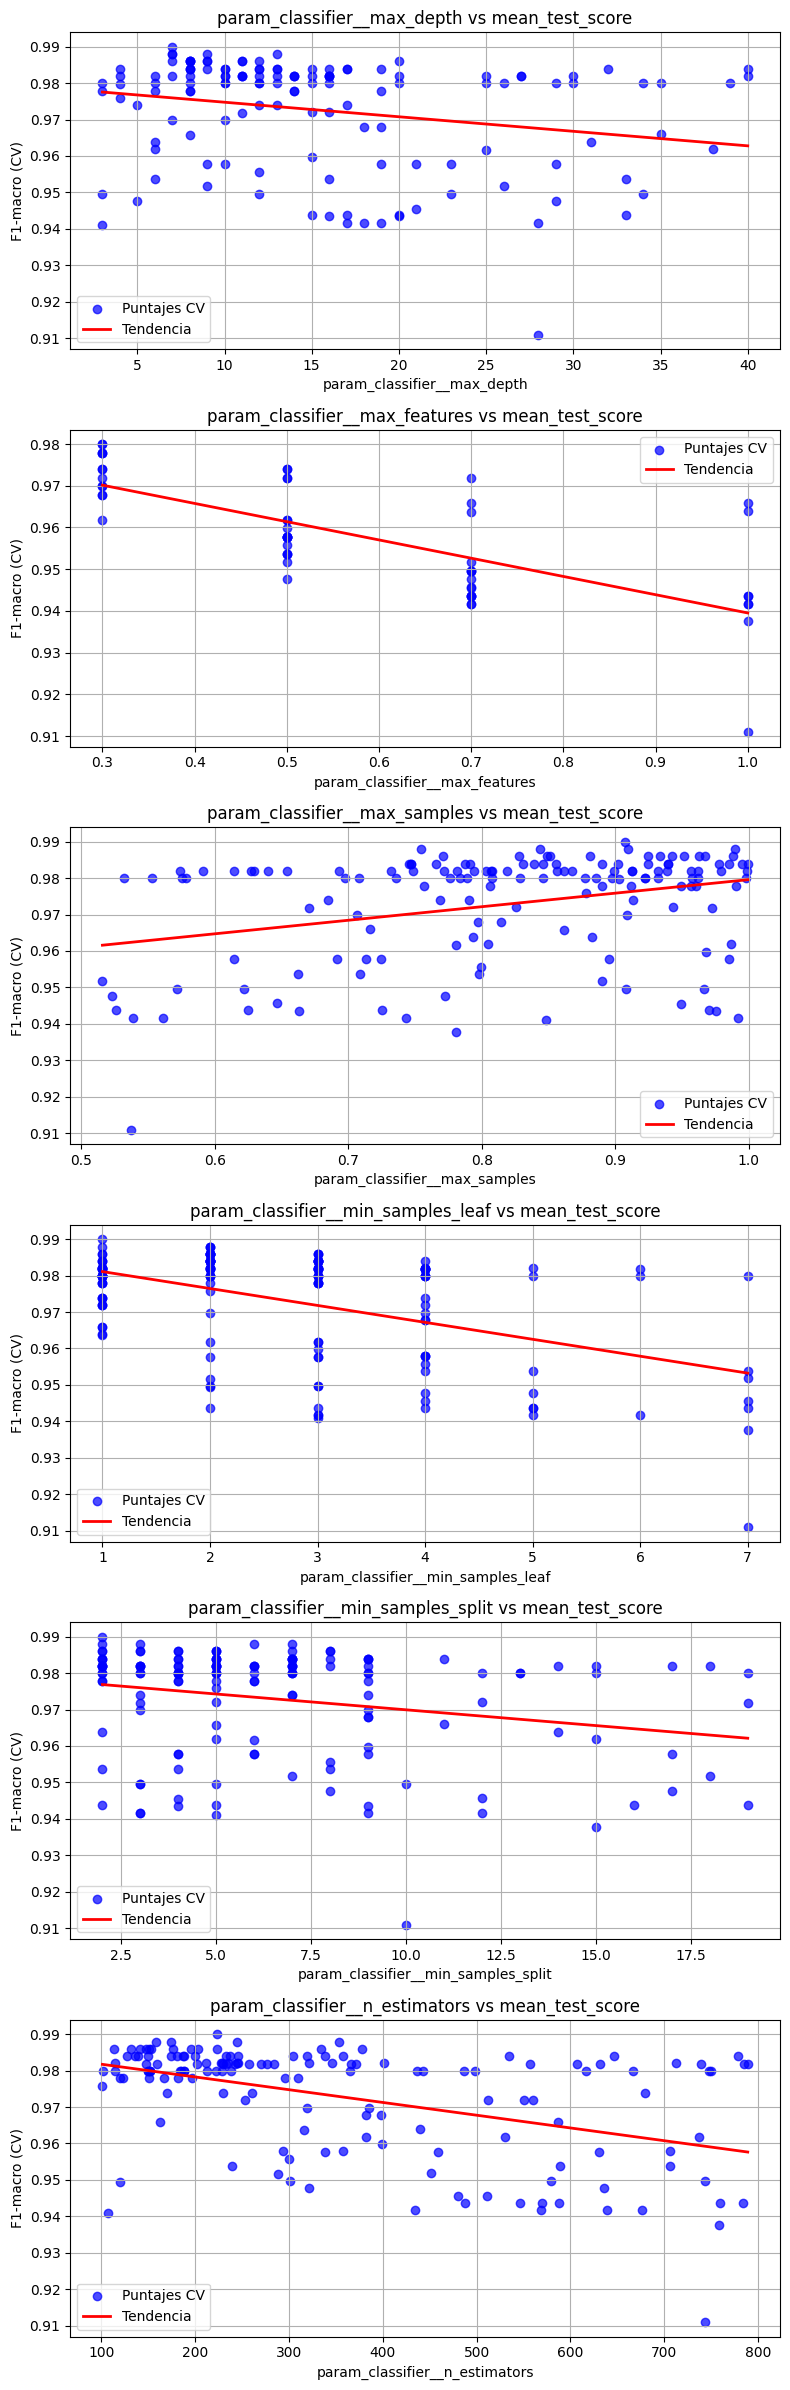

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === 1. Extraer resultados de cada búsqueda ===
# Access the search results from the resultados_globales list
resultados_dict = {
    item["espacio"]: pd.DataFrame(item["search_results"])
    for item in resultados_globales
}

# === 2. Unir todos los resultados en un solo DataFrame ===
df_all = pd.concat(
    [df.assign(espacio=k) for k, df in resultados_dict.items()],
    ignore_index=True
)

# === 3. Reorganizar datos para facilitar el graficado ===
param_cols = [c for c in df_all.columns if c.startswith("param_")]
df_melt = df_all.melt(
    id_vars=["mean_test_score", "espacio"],
    value_vars=param_cols,
    var_name="parametro",
    value_name="valor"
)

# === 4. Crear gráficos ===
parametros = df_melt["parametro"].unique()
num_plots = len(parametros)

fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(8, 4*num_plots))
if num_plots == 1:
    axes = [axes]

for ax, param in zip(axes, parametros):
    sub = df_melt[df_melt["parametro"] == param]

    # Dispersión básica
    # Ensure that 'valor' column is numeric before plotting
    sub['valor_numeric'] = pd.to_numeric(sub['valor'], errors='coerce')
    ax.scatter(sub["valor_numeric"], sub["mean_test_score"], alpha=0.7, color="blue", label="Puntajes CV")
    ax.set_title(f"{param} vs mean_test_score")
    ax.set_xlabel(param)
    ax.set_ylabel("F1-macro (CV)")
    ax.grid(True)

    # === 5. Línea de tendencia (si aplica) ===
    # Solo si el valor del hiperparámetro es numérico
    try:
        # Filter out non-numeric values for regression
        numeric_sub = sub.dropna(subset=['valor_numeric'])
        if len(numeric_sub) > 1:  # Need at least 2 points for a line
            X = numeric_sub["valor_numeric"].values.reshape(-1, 1)
            y = numeric_sub["mean_test_score"].values
            reg = LinearRegression().fit(X, y)
            x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            y_pred = reg.predict(x_range)
            ax.plot(x_range, y_pred, color="red", linewidth=2, label="Tendencia")
    except Exception as e:
        print(f"No se pudo trazar tendencia para {param}: {e}")

    ax.legend()

plt.tight_layout()
plt.show()

**Ranking de importancia**

Hemos creado un ranking de importancia para nuestro modelo, basados en la correlación con score de cada hiperparámetro

🏆 Ranking de importancia de hiperparámetros según correlación con el score:

                     Hiperparámetro  Importancia (|correlación|)
     param_classifier__max_features                     0.556763
 param_classifier__min_samples_leaf                     0.480280
     param_classifier__n_estimators                     0.469047
      param_classifier__max_samples                     0.322612
param_classifier__min_samples_split                     0.243569
        param_classifier__max_depth                     0.063290


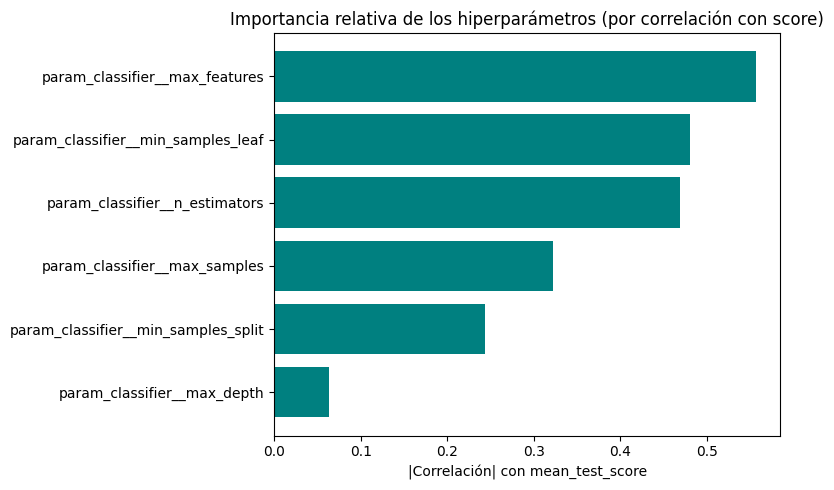

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. Consolidar resultados de todas las búsquedas ===
resultados_dict = {
    item["espacio"]: pd.DataFrame(item["search_results"])
    for item in resultados_globales # Access results from the list
}

df_all = pd.concat(
    [df.assign(espacio=k) for k, df in resultados_dict.items()],
    ignore_index=True
)

# === 2. Seleccionar hiperparámetros y score ===
param_cols = [c for c in df_all.columns if c.startswith("param_")]
df_params = df_all[param_cols + ["mean_test_score"]].copy()

# === 3. Convertir valores categóricos a numéricos para correlación ===
for col in param_cols:
    if df_params[col].dtype == "object" or isinstance(df_params[col].iloc[0], str):
        le = LabelEncoder()
        # Only fit_transform if there are non-null values to avoid errors
        if df_params[col].notna().any():
          df_params[col] = le.fit_transform(df_params[col].astype(str))
        else:
          # If all values are null, fill with a placeholder or drop the column
          df_params[col] = np.nan # Or df_params = df_params.drop(columns=[col])


# === 4. Calcular correlaciones absolutas ===
# Drop columns with all NaN values before calculating correlation
df_params = df_params.dropna(axis=1, how='all')
corrs = df_params.corr(numeric_only=True)["mean_test_score"].drop("mean_test_score").abs()
ranking = corrs.sort_values(ascending=False).reset_index()
ranking.columns = ["Hiperparámetro", "Importancia (|correlación|)"]

# === 5. Mostrar ranking ===
print("🏆 Ranking de importancia de hiperparámetros según correlación con el score:\n")
print(ranking.to_string(index=False))

# === 6. Visualizar (opcional) ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(ranking["Hiperparámetro"], ranking["Importancia (|correlación|)"], color="teal")
plt.gca().invert_yaxis()
plt.title("Importancia relativa de los hiperparámetros (por correlación con score)")
plt.xlabel("|Correlación| con mean_test_score")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Cargar dataset
df = pd.read_csv("/content/sample_data/verifactura_dataset_500.xlsx", sep=";", engine="python", encoding="utf-8")
y_col = "CLASE"

# 2) Limpiar strings y target
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace(
        {"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan, "NULL": np.nan}
    )

df_sup = df.dropna(subset=[y_col]).copy()

# 3) Manejo de clases raras
vc = df_sup[y_col].value_counts()
rare = vc[vc < 2].index.tolist()
df_rare = df_sup[df_sup[y_col].isin(rare)].copy()
df_main = df_sup[~df_sup[y_col].isin(rare)].copy()

# Split
if len(df_main) >= 2 * df_main[y_col].nunique():
    test_frac = max(0.2, df_main[y_col].nunique() / len(df_main) + 1e-9)
    Xtr_main, Xte_main = train_test_split(
        df_main, test_size=test_frac, random_state=42, stratify=df_main[y_col]
    )
else:
    Xtr_main, Xte_main = train_test_split(df_main, test_size=0.2, random_state=42)

train_df = pd.concat([Xtr_main, df_rare], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
test_df  = Xte_main.copy().reset_index(drop=True)

train_X, train_y = train_df.drop(columns=[y_col]), train_df[y_col]
test_X,  test_y  = test_df.drop(columns=[y_col]),  test_df[y_col]

print("Distribución TRAIN:", train_y.value_counts().to_dict())
print("Distribución TEST :", test_y.value_counts().to_dict())

# 4) Pipeline
num_cols = train_X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train_X.columns if c not in num_cols]

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))  # devuelve sparse
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pipe = ImbPipeline([
    ("prep", prep),
    ("ros", RandomOverSampler(random_state=42))
])

# Fit + transform
Xtr, ytr = pipe.fit_resample(train_X, train_y)
Xte = pipe.named_steps["prep"].transform(test_X)

# 5) Modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xtr, ytr)
y_pred = clf.predict(Xte)

# 6) Métricas
print("Accuracy:", accuracy_score(test_y, y_pred))
print("F1 macro:", f1_score(test_y, y_pred, average="macro"))
print("\nReporte:\n", classification_report(test_y, y_pred))

# Matriz de confusión
cm = confusion_matrix(test_y, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - RandomForest")
plt.show()